In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.nn import tanh, softmax, relu
from tensorflow.keras import Model
from PIL import Image
import glob
import pickle
from tqdm import tqdm
import time

# Load train development and test images

In [2]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [3]:
# load all images
img = glob.glob(images+'*.jpg')

In [4]:
def split_data(txt):
    result = []
    for i in img:
        if i[len(images):] in txt:
            result.append(i)
    return result

In [5]:
# getting training images from all images
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
train_img = split_data(train_images)
len(train_img)

6000

In [6]:
# getting development images from all images
dev_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))
dev_img = split_data(dev_images)
len(dev_img)

1000

In [7]:
# getting test images from all images
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = split_data(test_images)
len(test_img)

1000

In [8]:
#preprocessing is required by InceptionV3 model
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [9]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [10]:
# get InceptionV3 model from keras application
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [11]:
# the output of new model is the last layer of InceptionV3 before softmax layer
new_input = model.input
hidden_layer = model.layers[-1].output
model_new = tf.keras.Model(new_input, hidden_layer)

In [11]:
def encode(image):
    image = preprocess(image)
    result = model_new.predict(image)
    result = np.reshape(result,(result.shape[0],result.shape[1]*result.shape[2],result.shape[3]))
    return result

In [130]:
# processing all train images. The encoding_train dict saves vetor representation of all train images
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [03:49<00:00, 27.13it/s]


In [131]:
# save encoding_train dict as pickle for future use
with open("encoded_images_train.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [12]:
encoding_train = pickle.load(open('encoded_images_train.p', 'rb'))

In [133]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [00:37<00:00, 26.18it/s]


In [134]:
with open("encoded_images_test.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [13]:
encoding_test = pickle.load(open('encoded_images_test.p', 'rb'))

# load caption for train development and test set

In [14]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [15]:
captions = open(token, 'r').read().strip().split('\n')

In [16]:
# load all captions
all_captions = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in all_captions:
        all_captions[row[0]].append(row[1])
    else:
        all_captions[row[0]] = [row[1]]

In [17]:
#getting train captions from all captions
train_captions = {}
for i in train_img:
    if i[len(images):] in all_captions:
        train_captions[i] = all_captions[i[len(images):]]

In [18]:
#getting dev captions from all captions
dev_captions = {}
for i in dev_img:
    if i[len(images):] in all_captions:
        dev_captions[i] = all_captions[i[len(images):]]

In [19]:
#getting test captions from all captions
test_captions = {}
for i in test_img:
    if i[len(images):] in all_captions:
        test_captions[i] = all_captions[i[len(images):]]

In [20]:
# add '<start>', '<end>' tags for all captions
caps = []
for key, val in train_captions.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [21]:
# using keras tokenizer to creat the tokenized vectors for train captions
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(caps)
train_seqs = tokenizer.texts_to_sequences(caps)

In [22]:
# padding each vector to the max_length of the captions
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(caps)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [23]:
# get the length of longest caption
max_length = max(len(t) for t in cap_vector)

# Create dataset for trainning

In [24]:
# create dataset for training
x_train = []
y_train = []
i = 0
for key, val in train_captions.items():
    for v in val:
        image = encoding_train[key[len(images):]].reshape(64,2048)
        x_train.append(image)
        cap = cap_vector[i]
        y_train.append(cap)
        i = i+1

In [25]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(1000).batch(16)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define model

In [27]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
features_shape = 2048
BATCH_SIZE = 16
num_steps = 30000 // BATCH_SIZE

In [28]:
# follow the tensorflow 2.0 tourtial (https://www.tensorflow.org/alpha/tutorials/quickstart/advanced)

In [29]:
class Attention(Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, features, hidden):
    hidden = tf.expand_dims(hidden, 1)
    score = tanh(self.W1(features) + self.W2(hidden))
    attention_weights = softmax(self.V(score), axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [30]:
class CNN_Encoder(Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = relu(x)
        return x

In [31]:
class RNN_Decoder(Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = Dense(self.units)
    self.fc2 = Dense(vocab_size)
    self.attention = Attention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    output, _ ,state = self.lstm(x)

    x = self.fc1(output)
    x = tf.reshape(x, (x.shape[0]*x.shape[1], x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [36]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# encoder.load_weights('./checkpoints/encoder_checkpoint')
# decoder.load_weights('./checkpoints/decoder_checkpoint')

W0517 20:25:26.055322 140370727003968 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa91c085400>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# loss_function should ignore <tap>
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [38]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
        
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [42]:
EPOCHS = 10

for epoch in range(EPOCHS):
    batch = 0
    start = time.time()
    total_loss = 0
    for (img_tensor, target) in  train_ds: 
        batch = batch + 1
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    

Epoch 1 Batch 100 Loss 0.5727
Epoch 1 Batch 200 Loss 0.7248
Epoch 1 Batch 300 Loss 0.6779
Epoch 1 Batch 400 Loss 0.9206
Epoch 1 Batch 500 Loss 0.6136
Epoch 1 Batch 600 Loss 0.6904
Epoch 1 Batch 700 Loss 0.7193
Epoch 1 Batch 800 Loss 0.7773
Epoch 1 Batch 900 Loss 0.5651
Epoch 1 Batch 1000 Loss 0.5918
Epoch 1 Batch 1100 Loss 0.7037
Epoch 1 Batch 1200 Loss 0.5436
Epoch 1 Batch 1300 Loss 0.7129
Epoch 1 Batch 1400 Loss 0.6400
Epoch 1 Batch 1500 Loss 0.6664
Epoch 1 Batch 1600 Loss 0.5597
Epoch 1 Batch 1700 Loss 0.6322
Epoch 1 Batch 1800 Loss 0.5648
Epoch 1 Loss 0.670480
Time taken for 1 epoch 188.59862399101257 sec

Epoch 2 Batch 100 Loss 0.5496
Epoch 2 Batch 200 Loss 0.6801
Epoch 2 Batch 300 Loss 0.6238
Epoch 2 Batch 400 Loss 0.8343
Epoch 2 Batch 500 Loss 0.5818
Epoch 2 Batch 600 Loss 0.6425
Epoch 2 Batch 700 Loss 0.6892
Epoch 2 Batch 800 Loss 0.6977
Epoch 2 Batch 900 Loss 0.5304
Epoch 2 Batch 1000 Loss 0.5765
Epoch 2 Batch 1100 Loss 0.6560
Epoch 2 Batch 1200 Loss 0.5113
Epoch 2 Batch 1300 

In [43]:
encoder.save_weights('./checkpoints/encoder_checkpoint')
decoder.save_weights('./checkpoints/decoder_checkpoint')

# test result

In [44]:
def test():
    test_n = np.random.randint(0, 1000)
    test = encoding_test[test_img[test_n][len(images):]].reshape(64,2048)
    for c in test_captions[test_img[test_n]]:
        print (c)
    features = encoder(test)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    attention_plot = np.zeros((max_length, 64))
    hidden = decoder.reset_state(batch_size=1)
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            break

        dec_input = tf.expand_dims([predicted_id], 0)
    print (result)
    return test_n

a black and white dog jumping in the air to catch a Frisbee
A black and white dog jumping in a yard .
A black dog jumps for a Frisbee in a backyard with a white fence .
A dog catches a flying disk in a yard with a tree .
A jumping dog in motion .
['a', 'black', 'and', 'white', 'dog', 'is', 'jumping', 'up', '<end>']


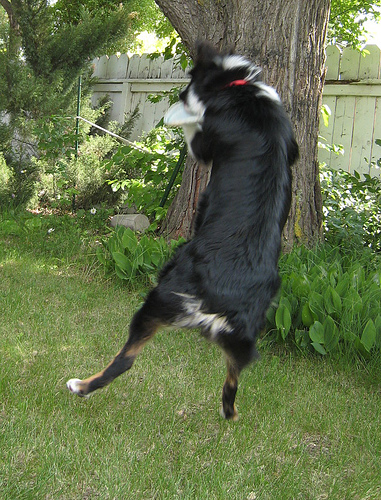

In [85]:
 Image.open(test_img[test()])

A brown and white dog is running with its mouth open accross a field .
A brown and white dog running in a field covered in yellow flowers .
A dog running toward the camera in a field .
A while dog with a spot on his eye running through a meadow .
A white dog with a brown patch over his eye runs through a grassy field covered in dandelions .
['a', 'dog', 'is', 'running', 'on', 'the', 'grass', '<end>']


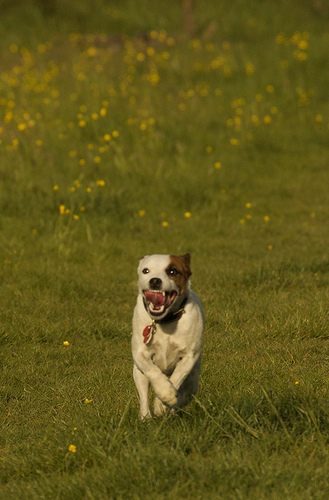

In [48]:
 Image.open(test_img[test()])

A black dog is slowly crossing a fallen log that is outstretched over a stream of water .
A dog crossing a river on a bridge made of a fallen tree .
A dog walks on a log across a small river .
The black dog is walking along a tree trunk bridge over water .
The dog walks across the stream on a fallen log .
['a', 'black', 'dog', 'is', 'jumping', 'over', 'the', 'water', '<end>']


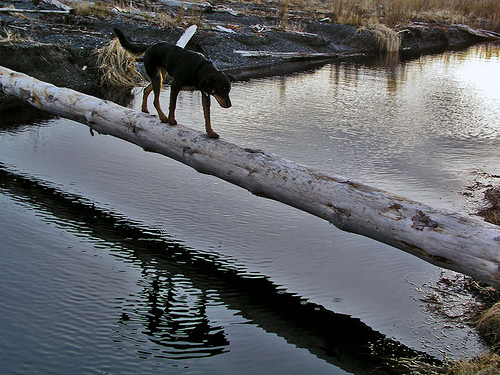

In [54]:
 Image.open(test_img[test()])

A man surfing a wave .
A surfer in a wetsuite jumps waves .
a surfer is riding his board over a wave .
A surfer on a white board catches a wave .
The man turns with the wave on his surfboard .
['a', 'surfer', 'is', 'surfing', 'a', 'large', 'wave', '<end>']


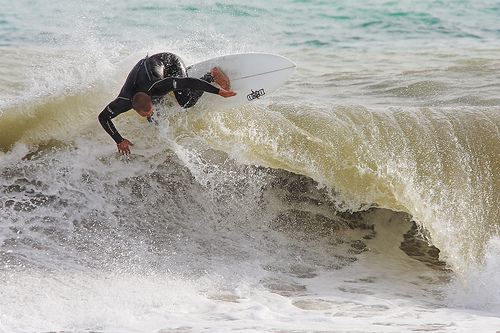

In [67]:
 Image.open(test_img[test()])

A man is skiing down a mountain .
A person dressed in red and grey is skiing down a snowy slope .
a skier is throwing up snow as he skis off piste .
A skier skiing downhill in a cloud of snow .
A skier wearing white sunglasses is skiing down a snowy mountain very fast .
['a', 'man', 'is', 'skiing', 'down', 'a', 'snowy', 'mountain', 'area', '<end>']


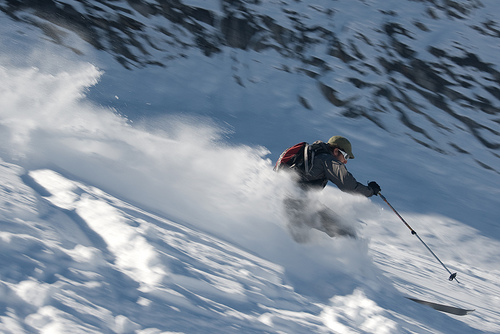

In [68]:
 Image.open(test_img[test()])

A dog is jumping in the air trying to catch a red Frisbee .
A dog jumps to catch an orange Frisbee .
A yellow dog chases a red Frisbee next to a black pot .
Grayish dog is playing Frisbee in the yard .
The yellow dog is trying to catch a red Frisbee .
['a', 'dog', 'jumps', 'to', 'catch', 'a', 'frisbee', '<end>']


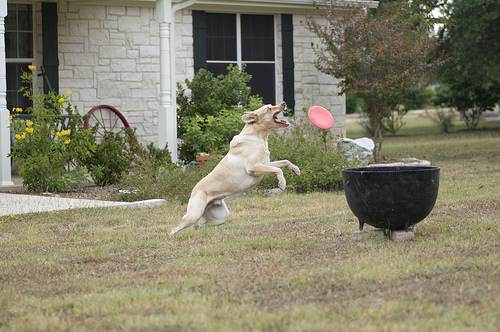

In [83]:
 Image.open(test_img[test()])